In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from tensorflow.keras.layers import Conv1D,LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
import plotly.express as px


In [ ]:
df= pd.read_csv("/content/^NSEI.csv")
df.dropna(inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3855 entries, 0 to 3884
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       3855 non-null   object 
 1   Open       3855 non-null   float64
 2   High       3855 non-null   float64
 3   Low        3855 non-null   float64
 4   Close      3855 non-null   float64
 5   Adj Close  3855 non-null   float64
 6   Volume     3855 non-null   float64
dtypes: float64(6), object(1)
memory usage: 240.9+ KB


In [ ]:
df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)

In [ ]:
# Select the input features
df= df.astype(float)

In [ ]:
input_features = ['High', 'Low', 'Close', 'Adj Close', 'Volume']

In [ ]:
correlation_matrix = df[input_features].corr()
fig = px.imshow(correlation_matrix,
                x=correlation_matrix.columns,
                y=correlation_matrix.columns,
                color_continuous_scale='RdBu',
                title='Correlation Heatmap for new df')
fig.show()


In [ ]:
data = df[input_features[:-1]]

In [ ]:
correlation_matrix = data.corr()
fig = px.imshow(correlation_matrix,
                x=correlation_matrix.columns,
                y=correlation_matrix.columns,
                color_continuous_scale='RdBu',
                title='Correlation Heatmap for new df')
fig.show()


In [ ]:
# Removing Adj Close as [Close, Adj Close] are almost identical
data=data[input_features[:-2]]
correlation_matrix = data.corr()
fig = px.imshow(correlation_matrix,
                x=correlation_matrix.columns,
                y=correlation_matrix.columns,
                color_continuous_scale='RdBu',
                title='Correlation Heatmap for Final df')
fig.show()


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3855 entries, 2007-09-17 to 2023-06-09
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   High    3855 non-null   float64
 1   Low     3855 non-null   float64
 2   Close   3855 non-null   float64
dtypes: float64(3)
memory usage: 120.5 KB


In [ ]:
data['Open']=df["Open"]

In [ ]:
np.random.seed(1)
scaler= StandardScaler()
scaled_features = pd.DataFrame(scaler.fit_transform(data), columns=data.columns, index=data.index)

print(scaled_features)

                High       Low     Close      Open
Date                                              
2007-09-17 -1.051559 -1.046676 -1.054260 -1.049147
2007-09-18 -1.050905 -1.046987 -1.041967 -1.054948
2007-09-19 -1.006410 -1.030544 -0.997579 -1.041570
2007-09-20 -1.001216 -0.989639 -0.993954 -0.997590
2007-09-21 -0.978672 -0.986635 -0.972493 -0.993277
...              ...       ...       ...       ...
2023-06-05  2.297716  2.328108  2.307782  2.308639
2023-06-06  2.293580  2.315853  2.309010  2.305971
2023-06-07  2.321199  2.340841  2.339390  2.321409
2023-06-08  2.330457  2.335958  2.317488  2.335645
2023-06-09  2.306392  2.321550  2.300522  2.319099

[3855 rows x 4 columns]


In [ ]:

def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        seq = data[i : (i + n_steps), :-1]  # Exclude the last column
        X.append(seq)
        y.append(data[i + n_steps, -1])  # select the last column (Open)
    return np.array(X), np.array(y)




In [ ]:
seq_length = 14 


X, y = create_sequences(scaled_features.values, seq_length)

# Split the data into training and testing sets
train_size = int(0.8 * len(X))
trainX, trainY = X[:train_size], y[:train_size]
testX, testY = X[train_size:], y[train_size:]

# Reshape the input data for LSTM
trainX = trainX.reshape((trainX.shape[0], trainX.shape[1], trainX.shape[2]))
testX = testX.reshape((testX.shape[0], testX.shape[1], testX.shape[2]))



In [ ]:

model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(LSTM(units=64, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(units=1))



model.compile(optimizer='adam', loss='mse')
# model.summary()
# fit the model
early_stopping = EarlyStopping(
    monitor='loss',   
    patience=3,           
    restore_best_weights=True   
)
history = model.fit(trainX, trainY, epochs=30, batch_size=32, validation_split=0.2, verbose=1,callbacks=[early_stopping])



Epoch 1/30
77/77 [==============================] - 2s 11ms/step - loss: 0.0461 - val_loss: 0.0040
Epoch 2/30
77/77 [==============================] - 1s 8ms/step - loss: 0.0094 - val_loss: 0.0042
Epoch 3/30
77/77 [==============================] - 1s 8ms/step - loss: 0.0082 - val_loss: 0.0036
Epoch 4/30
77/77 [==============================] - 1s 9ms/step - loss: 0.0076 - val_loss: 0.0076
Epoch 5/30
77/77 [==============================] - 1s 8ms/step - loss: 0.0075 - val_loss: 0.0047
Epoch 6/30
77/77 [==============================] - 1s 8ms/step - loss: 0.0067 - val_loss: 0.0049
Epoch 7/30
77/77 [==============================] - 1s 8ms/step - loss: 0.0068 - val_loss: 0.0129
Epoch 8/30
77/77 [==============================] - 1s 10ms/step - loss: 0.0067 - val_loss: 0.0070
Epoch 9/30
77/77 [==============================] - 1s 16ms/step - loss: 0.0066 - val_loss: 0.0085
Epoch 10/30
77/77 [==============================] - 1s 15ms/step - loss: 0.0063 - val_loss: 0.0182
Epoch 11/30
77/

Predicting for next 16 days

In [ ]:
from tabulate import tabulate
d=-1
# Make predictions
predictions = model.predict(testX[0:d,:,:])

# Calculate MSE
mse = np.mean((predictions - testY) ** 2)

# Calculate RMSE
rmse = np.sqrt(mse)

# Calculate MAE
mae = np.mean(np.abs(predictions - testY))

# Create the table data
table_data = [["Metric", "Value"],
              ["MSE", mse],
              ["RMSE", rmse],
              ["MAE", mae]]

# Print the table
print(tabulate(table_data, headers="firstrow"))


24/24 [==============================] - 0s 3ms/step
Metric       Value
--------  --------
MSE       1.01847
RMSE      1.00919
MAE       0.811212


In [ ]:
# Inverse Transform

prediction_rep = np.repeat(predictions, data.shape[1], axis=-1)
y_pred = scaler.inverse_transform(prediction_rep)[:,0]

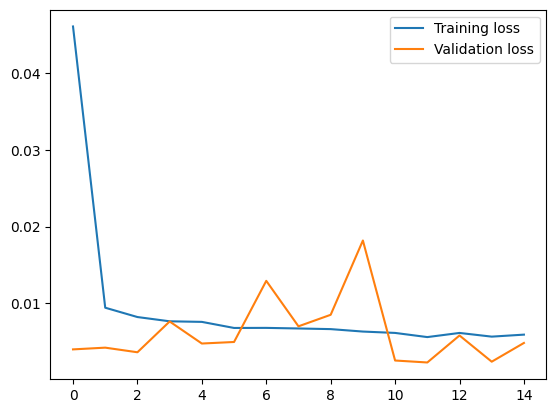

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [ ]:
import plotly.graph_objects as go

# Get the number of data points in the training set
train_size = len(trainY)

# Create an array to represent the x-axis values
x_axis = list(range(train_size, train_size + len(testY[0:d])))

# Create traces for training labels, actual test labels, and predictions
trace1 = go.Scatter(x=list(range(train_size)), y=data["Open"][:len(trainY)], mode='lines', name='Training Labels')
trace2 = go.Scatter(x=x_axis, y=data["Open"][len(trainY):], mode='lines', name='Actual Test Labels')
trace3 = go.Scatter(x=x_axis, y=y_pred.flatten(), mode='lines', name='Predictions on Test Data')

# Create the plot layout
layout = go.Layout(
    title='Comparison of Training Labels, Actual Test Labels, and Predictions',
    xaxis=dict(title='Time', rangeslider=dict(visible=True)),  # Add rangeslider with visible=True
    yaxis=dict(title='Opening Price')
)

# Create the figure and add the traces
fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)

# Display the plot
fig.show()
